### InceptionV3 (previously ResNet50) Keras baseline model 

This notebook takes you through some important steps in building a deep convnet in Keras for multilabel classification of brain CT scans. 


*Update (1):*
* *training for 4 epochs instead of 3.*
* *batch size lowered to 16 from 32.*
* *training without learning rate decay.*
* *Weighted BCE instead of "plain" BCE*
* *training data lowered to 80% from 90%.*


*Update (2):*
* *adding competition metric for training*
* *using custom Callback for validation and test sets instead of the `run()` function and 'global epochs'*
* *training with "plain" BCE again*
* *merging TestDataGenerator and TrainDataGenerator into one*
* *adding undersampling (see inside `on_epoch_end`), will now run 6 epochs*

*Update (3):*
* *skipping/removing windowing (value clipping), but the transformation to Hounsfield Units is kept*
* *removing initial layer (doing np.stack((img,)&ast;3, axis=-1)) instead*
* *reducing learning rate to 5e-4 and add decay*
* *increasing batch size to 32 from 16*
* *Increasing training set to 90% of the data (10% for validation)*
* *slight increase in undersampling*
* *fixed some hardcoding for input dims/sizes*
* *training with weighted BCE again*

*Update (4):*
* *Trying out InceptionV3, instead of ResNet50*
* *undersampling without weights*
* *adding dense layers with dropout before output*
* *clipping HUs between -50 and 450 (probably the most relevant value-space?)*
* *normalization is now mapping input to 0 to 1 range, instead of -1 to 1.*
* *doing 5 epochs instead of 6*

*Update (5):*
* *Got some inspiration from [this great](https://www.kaggle.com/reppic/gradient-sigmoid-windowing) kernel by Ryan Epp*
* *Thus I'm trying out the sigmoid (brain + subdural + bone) to see if it improves the log loss*
* *Number of epochs reduced to 4, increased undersampling, and validation predictions removed due to limited time*


In [1]:
#pip install efficientnet --quiet

In [2]:
#!pip install git+https://github.com/qubvel/classification_models.git

In [3]:
import numpy as np
import pandas as pd
import pydicom
import os
import matplotlib.pyplot as plt
import collections
from tqdm import tqdm_notebook as tqdm
from datetime import datetime

from math import ceil, floor
import cv2

import tensorflow as tf
import keras

from albumentations import (
    Compose,
    HorizontalFlip, ShiftScaleRotate,VerticalFlip,
    RandomBrightness,RandomCrop,RandomContrast
)
import sys
#import cupy as cp
#from classification_models.keras import Classifiers

#import albumentations
# from keras_applications.resnet import ResNet50
#from keras_applications.inception_v3 import InceptionV3
#from efficientnet.keras import EfficientNetB2
#from keras_applications.inception_resnet_v2 import InceptionResNetV2
from keras_applications.densenet import DenseNet121
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import f1_score
from keras.callbacks import Callback

#print(os.listdir('../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection'))

test_images_dir = '../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_test/'
train_images_dir = '../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/'


Using TensorFlow backend.


In [4]:
os.getcwd()

'/kaggle/working'

In [5]:
len(os.listdir('../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train'))

752803

In [6]:
os.listdir('../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train')[0]

'ID_e1b0c40f8.dcm'

In [7]:
os.listdir('../input/densenet121-4-epochs')

['model.h5']

### 0. Sigmoid (brain + subudral + bone)
Many thanks to [Ryan Epp](https://www.kaggle.com/reppic/gradient-sigmoid-windowing). Code is taken from his kernel (see his kernel for more information and other peoples work --- for example [David Tang](https://www.kaggle.com/dcstang/see-like-a-radiologist-with-systematic-windowing), [Marco](https://www.kaggle.com/marcovasquez/basic-eda-data-visualization), [Nanashi](https://www.kaggle.com/jesucristo/rsna-introduction-eda-models), and [Richard McKinley](https://www.kaggle.com/omission/eda-view-dicom-images-with-correct-windowing)). At first I thought I couldn't use sigmoid windowing for this kernel because of how expensive it is to do, but I could resize the image prior to the transformation to save a lot of computation. Not sure how much this will affect the performance of the training, but it really speeded it up.

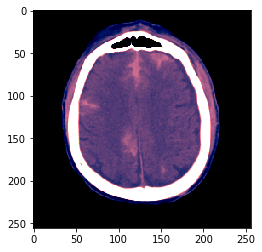

In [8]:
from math import log

def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000
    return dcm

def window_image(dcm,window_center, window_width,desired_size,U=1.0, eps=(1.0 / 255.0)):
    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        dcm = correct_dcm(dcm)
    
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img = cv2.resize(img, desired_size[:2], interpolation=cv2.INTER_LINEAR)
    
    #img = cp.array(np.array(img))
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)

    return img

def bsb_window(dcm,desired_size=(256,256,3)):
    brain_img = window_image(dcm, 40, 80,desired_size)
    subdural_img = window_image(dcm, 80, 200,desired_size)
    soft_img = window_image(dcm, 40, 380,desired_size)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img

# Sanity Check
# Example dicoms: ID_2669954a7, ID_5c8b5d701, ID_52c9913b1

dicom = pydicom.dcmread(train_images_dir + 'ID_5c8b5d701' + '.dcm')
#                                     ID  Label
# 4045566          ID_5c8b5d701_epidural      0
# 4045567  ID_5c8b5d701_intraparenchymal      1
# 4045568  ID_5c8b5d701_intraventricular      0
# 4045569      ID_5c8b5d701_subarachnoid      1
# 4045570          ID_5c8b5d701_subdural      1
# 4045571               ID_5c8b5d701_any      1
plt.imshow(bsb_window(dicom), cmap=plt.cm.bone);


Check (with an example) if the correction works (visually)

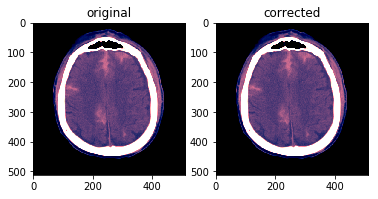

In [9]:
def window_with_correction(dcm, window_center, window_width):
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        dcm = correct_dcm(dcm)
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def window_without_correction(dcm, window_center, window_width):
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def window_testing(img, window):
    brain_img = window(img, 40, 80)
    subdural_img = window(img, 80, 200)
    soft_img = window(img, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img

# example of a "bad data point" (i.e. (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100) == True)
dicom = pydicom.dcmread(train_images_dir + "ID_5c8b5d701" + ".dcm")

fig, ax = plt.subplots(1, 2)

ax[0].imshow(window_testing(dicom, window_without_correction), cmap=plt.cm.bone);
ax[0].set_title("original")
ax[1].imshow(window_testing(dicom, window_with_correction), cmap=plt.cm.bone);
ax[1].set_title("corrected");

### 1. Helper functions

* read and transform dcms to 3-channel inputs for e.g. InceptionV3. 
* uses `sigmoid_bsb_window` from previous cell

\* Source for windowing (although now partly removed from this kernel): https://www.kaggle.com/omission/eda-view-dicom-images-with-correct-windowing

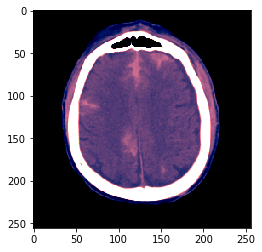

In [10]:
def _read(path, desired_size):
    """Will be used in DataGenerator"""
    
    dcm = pydicom.dcmread(path)
    
    try:
        img = bsb_window(dcm,desired_size)
    except:
        img = np.zeros(desired_size)
    
    return img

# Another sanity check 
plt.imshow(
    _read(train_images_dir+'ID_5c8b5d701'+'.dcm', (256, 256)), cmap=plt.cm.bone
);

### 2. Data generators

Inherits from keras.utils.Sequence object and thus should be safe for multiprocessing.


In [11]:
class DataGenerator(keras.utils.Sequence):

    def __init__(self, list_IDs, labels=None, batch_size=1, img_size=(512, 512, 1), 
                 img_dir=train_images_dir,augment=None, *args, **kwargs):

        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir
        self.on_epoch_end()
        self.augment = augment

    def __len__(self):
        return int(ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indices]
        
        if self.labels is not None:
            X, Y = self.__data_generation(list_IDs_temp)
            return X, Y
        else:
            X = self.__data_generation(list_IDs_temp)
            return X
        
    def on_epoch_end(self):
        
        
        if self.labels is not None: # for training phase we undersample and shuffle
            # keep probability of any=0 and any=1
            keep_prob = self.labels.iloc[:, 0].map({0: 0.3, 1: 1})
            keep = (keep_prob > np.random.rand(len(keep_prob)))
            self.indices = np.arange(len(self.list_IDs))[keep]
            np.random.shuffle(self.indices)
        else:
            self.indices = np.arange(len(self.list_IDs))

    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.img_size))
        
        if self.labels is not None: # training phase
            Y = np.empty((self.batch_size, 6), dtype=np.float32)
        
            for i, ID in enumerate(list_IDs_temp):
                X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
                Y[i,] = self.labels.loc[ID].values
        
            if self.augment:
                X = self.__augment(X)
            return X, Y
        
        else: # test phase
            for i, ID in enumerate(list_IDs_temp):
                X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
            
            return X
        
    def __random_transform(self,img):
        composition = Compose([
            HorizontalFlip(),
            VerticalFlip(),
            ShiftScaleRotate(rotate_limit=45, shift_limit=0.15, scale_limit=0.15),
            RandomBrightness(),
            RandomContrast()
        ])
        
        composed = composition(image=img)
        aug_img = composed['image']
        
        return aug_img
        
    def __augment(self,img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ] = self.__random_transform(img_batch[i, ])
        
        return img_batch

### 3a. loss function and metric

In [12]:
from keras import backend as K

def weighted_log_loss(y_true, y_pred):
    """
    Can be used as the loss function in model.compile()
    ---------------------------------------------------
    """
    
    class_weights = np.array([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    out = -(         y_true  * K.log(      y_pred) * class_weights
            + (1.0 - y_true) * K.log(1.0 - y_pred) * class_weights)
    
    return K.mean(out, axis=-1)


def _normalized_weighted_average(arr, weights=None):
    """
    A simple Keras implementation that mimics that of 
    numpy.average(), specifically for this competition
    """
    
    if weights is not None:
        scl = K.sum(weights)
        weights = K.expand_dims(weights, axis=1)
        return K.sum(K.dot(arr, weights), axis=1) / scl
    return K.mean(arr, axis=1)


def weighted_loss(y_true, y_pred):
    """
    Will be used as the metric in model.compile()
    ---------------------------------------------
    
    Similar to the custom loss function 'weighted_log_loss()' above
    but with normalized weights, which should be very similar 
    to the official competition metric:
        https://www.kaggle.com/kambarakun/lb-probe-weights-n-of-positives-scoring
    and hence:
        sklearn.metrics.log_loss with sample weights
    """
    
    class_weights = K.variable([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    loss = -(        y_true  * K.log(      y_pred)
            + (1.0 - y_true) * K.log(1.0 - y_pred))
    
    loss_samples = _normalized_weighted_average(loss, class_weights)
    
    return K.mean(loss_samples)


def weighted_log_loss_metric(trues, preds):
    """
    Will be used to calculate the log loss 
    of the validation set in PredictionCheckpoint()
    ------------------------------------------
    """
    class_weights = [2., 1., 1., 1., 1., 1.]
    
    epsilon = 1e-7
    
    preds = np.clip(preds, epsilon, 1-epsilon)
    loss = trues * np.log(preds) + (1 - trues) * np.log(1 - preds)
    loss_samples = np.average(loss, axis=1, weights=class_weights)

    return - loss_samples.mean()

def f1_score(y_true, y_pred):
    """
    f1 score

    :param y_true:
    :param y_pred:
    :return:
    """
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    return (2*precision*recall)/(precision+recall+ K.epsilon())



### 3b. Model

Model is divided into three parts: <br> 

* (REMOVED) The initial layer, which will transform/map input image of shape (\_, \_, 1) to another "image" of shape (\_, \_, 3).

* The new input image is then passed through InceptionV3 (which I named "engine"). InceptionV3 could be replaced by any of the available architectures in keras_application.

* Finally, the output from InceptionV3 goes through average pooling followed by two dense layers (including output layer).

In [13]:

class PredictionCheckpoint(keras.callbacks.Callback):
    
    def __init__(self, test_df, valid_df, 
                 test_images_dir=test_images_dir, 
                 valid_images_dir=train_images_dir, 
                 batch_size=32, input_size=(224, 224, 3)):
        
        self.test_df = test_df
        self.valid_df = valid_df
        self.test_images_dir = test_images_dir
        self.valid_images_dir = valid_images_dir
        self.batch_size = batch_size
        self.input_size = input_size
        
    def on_train_begin(self, logs={}):
        self.test_predictions = []
        self.valid_predictions = []
        
    def on_epoch_end(self,batch, logs={}):
        self.test_predictions.append(
            self.model.predict_generator(
                DataGenerator(self.test_df.index, None, self.batch_size, self.input_size, self.test_images_dir), verbose=2)[:len(self.test_df)])
        
        # Commented out to save time
#         self.valid_predictions.append(
#             self.model.predict_generator(
#                 DataGenerator(self.valid_df.index, None, self.batch_size, self.input_size, self.valid_images_dir), verbose=2)[:len(self.valid_df)])
        
#         print("validation loss: %.4f" %
#               weighted_log_loss_metric(self.valid_df.values, 
#                                    np.average(self.valid_predictions, axis=0, 
#                                               weights=[2**i for i in range(len(self.valid_predictions))])))
        # here you could also save the predictions with np.save()


class MyDeepModel:
    
    def __init__(self, engine, input_dims, batch_size=5, num_epochs=4, learning_rate=1e-3, 
                 decay_rate=1.0, decay_steps=1, weights="imagenet", verbose=1):
        
        self.engine = engine
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        self.weights = weights
        self.verbose = verbose
        self._build()

    def _build(self):
        
        
        engine = self.engine(include_top=False, weights=self.weights, input_shape=self.input_dims,
                             backend = keras.backend, layers = keras.layers,
                             models = keras.models, utils = keras.utils)
        
        x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(engine.output)
        x = keras.layers.Dropout(0.3)(x)
#         x = keras.layers.Dense(keras.backend.int_shape(x)[1], activation="relu", name="dense_hidden_1")(x)
#         x = keras.layers.Dropout(0.1)(x)
        out = keras.layers.Dense(6, activation="sigmoid", name='dense_output')(x)

        self.model = keras.models.Model(inputs=engine.input, outputs=out)
        
        #self.model.load_weights('../input/densenet121-4-epochs/model.h5')

        self.model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Nadam(), metrics=[weighted_loss,f1_score])
        
        
    

    def fit_and_predict(self, train_df, valid_df, test_df):
        
        # callbacks
        pred_history = PredictionCheckpoint(test_df, valid_df, input_size=self.input_dims)
        #checkpoint = keras.callbacks.ModelCheckpoint('model.h5', monitor='weighted_loss',verbose=1, save_best_only=True)
        scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: self.learning_rate * pow(self.decay_rate, floor(epoch / self.decay_steps)))
        
        history = self.model.fit_generator(
            DataGenerator(
                train_df.index, 
                train_df, 
                self.batch_size, 
                self.input_dims, 
                train_images_dir,
                augment=None
            ),
            epochs=self.num_epochs,
            verbose=self.verbose,
            use_multiprocessing=True,
            workers=4,
            callbacks=[scheduler]
        )
        
        return history
    
    def save(self, path):
        self.model.save_weights(path)
    
    def load(self, path):
        self.model.load_weights(path)

### 4. Read csv files


In [14]:
def read_testset(filename="../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_sample_submission.csv"):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    
    return df

def read_trainset(filename="../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train.csv"):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    
    """
    print(df.shape)
    ids = df['ID']
    
    duplicates = df[ids.isin(ids[ids.duplicated()])]
    
    print(duplicates['ID'].unique().shape,duplicates['ID'].shape)
    
    print(df[df.duplicated()==False].shape)
    
    duplicates_to_remove = [
        1598538, 1598539, 1598540, 1598541, 1598542, 1598543,
        312468,  312469,  312470,  312471,  312472,  312473,
        2708700, 2708701, 2708702, 2708703, 2708704, 2708705,
        3032994, 3032995, 3032996, 3032997, 3032998, 3032999
    ]
    
    df = df.drop(index=duplicates_to_remove)
    """
    df = df[df.duplicated()==False]
    df = df.reset_index(drop=True)
    
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    
    return df

    
test_df = read_testset()
df = read_trainset()

In [15]:
df.shape

(752803, 6)

In [16]:
test_df.head(3)

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_000000e27   0.5      0.5              0.5              0.5          0.5   
ID_000009146   0.5      0.5              0.5              0.5          0.5   
ID_00007b8cb   0.5      0.5              0.5              0.5          0.5   

                       
Diagnosis    subdural  
Image                  
ID_000000e27      0.5  
ID_000009146      0.5  
ID_00007b8cb      0.5

### 5. Train model and predict

*Using train, validation and test set* <br>

Training for 4 epochs with Adam optimizer, with a learning rate of 0.0005 and decay rate of 0.8. The validation predictions are \[exponentially weighted\] averaged over all 4 epochs (same goes for the test set submission later). `fit_and_predict` returns validation and test predictions for all epochs.


In [17]:
1/K.epsilon()

10000000.0

In [18]:
# train set (00%) and validation set (10%)
ss = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42).split(df.index)

# lets go for the first fold only
train_idx, valid_idx = next(ss)


#print(train_idx.shape,valid_idx.shape)
# obtain model
#SE_resnext50, preprocess_input = Classifiers.get('seresnext50')
model = MyDeepModel(engine=DenseNet121, input_dims=(224, 224, 3), batch_size=32, learning_rate=1e-3,
                    num_epochs=5, decay_rate=0.8, decay_steps=1, weights="imagenet", verbose=1)

# obtain test + validation predictions (history.test_predictions, history.valid_predictions)
history = model.fit_and_predict(df.iloc[train_idx], df.iloc[valid_idx], test_df)


29089792/29084464 [==============================] - 0s 0us/step
Epoch 1/5
8470/8470 [==============================] - 3735s 441ms/step - loss: 0.1823 - weighted_loss: 0.1958 - f1_score: 0.7189
Epoch 2/5
8475/8475 [==============================] - 3708s 438ms/step - loss: 0.1455 - weighted_loss: 0.1556 - f1_score: 0.7866
Epoch 3/5
8470/8470 [==============================] - 3698s 437ms/step - loss: 0.1304 - weighted_loss: 0.1394 - f1_score: 0.8111
Epoch 4/5
8462/8462 [==============================] - 3740s 442ms/step - loss: 0.1070 - weighted_loss: 0.1143 - f1_score: 0.8468


In [19]:
#keep_prob = df.iloc[train_idx].iloc[:, 0].map({0: 0.35, 1: 0.5})

In [20]:
#df.iloc[train_idx].iloc[:, 0]

In [21]:
#keep_prob.shape

In [22]:
#np.histogram(np.random.rand(len(keep_prob)))

In [23]:
keep_prob = df.iloc[train_idx].iloc[:, 0].map({0: 0.3, 1: 1})
keep = (keep_prob > np.random.rand(len(keep_prob)))

In [24]:
df.iloc[train_idx][keep]['Label']['any'].value_counts()

0    174234
1     97077
Name: any, dtype: int64

In [25]:
#np.histogram(np.random.rand(len(keep_prob)))

In [26]:
#df.iloc[train_idx][df.iloc[train_idx]['Label']['any']==0]

In [27]:
#keep.value_counts()

In [28]:
#self.indices = np.arange(len(self.list_IDs))[keep]

### 6. Submit test predictions

In [29]:
prediction = model.model.predict_generator(DataGenerator(test_df.index, None, 32, (224, 224, 3), test_images_dir), verbose=1)

#print(prediction.shape)

test_df_2 = test_df.copy()

#test_df.iloc[:, :] = np.average(history.test_predictions, axis=0, weights=[2**i for i in range(len(history.test_predictions))])
    #latest = history.test_predictions
    
test_df.iloc[:, :] = prediction[:len(test_df)]

test_df = test_df.stack().reset_index()

test_df.insert(loc=0, column='ID', value=test_df['Image'].astype(str) + "_" + test_df['Diagnosis'])

test_df = test_df.drop(["Image", "Diagnosis"], axis=1)

test_df.to_csv('submission.csv', index=False)
"""
#######################################################
test_df_2.iloc[:, :] = history.test_predictions[-1]

test_df_2 = test_df_2.stack().reset_index()

test_df_2.insert(loc=0, column='ID', value=test_df_2['Image'].astype(str) + "_" + test_df_2['Diagnosis'])

test_df_2 = test_df_2.drop(["Image", "Diagnosis"], axis=1)

test_df_2.to_csv('submission_last_pred.csv', index=False)
"""

3789/3789 [==============================] - 1384s 365ms/step


'\n#######################################################\ntest_df_2.iloc[:, :] = history.test_predictions[-1]\n\ntest_df_2 = test_df_2.stack().reset_index()\n\ntest_df_2.insert(loc=0, column=\'ID\', value=test_df_2[\'Image\'].astype(str) + "_" + test_df_2[\'Diagnosis\'])\n\ntest_df_2 = test_df_2.drop(["Image", "Diagnosis"], axis=1)\n\ntest_df_2.to_csv(\'submission_last_pred.csv\', index=False)\n'

In [30]:
test_df.head(10)

,ID,Label
0,ID_000000e27_any,7.002115e-02
1,ID_000000e27_epidural,1.234561e-03
2,ID_000000e27_intraparenchymal,2.187848e-03
3,ID_000000e27_intraventricular,6.774068e-05
4,ID_000000e27_subarachnoid,3.472114e-02
5,ID_000000e27_subdural,2.532288e-02
6,ID_000009146_any,3.576279e-06
7,ID_000009146_epidural,5.662441e-07
8,ID_000009146_intraparenchymal,3.010035e-06
9,ID_000009146_intraventricular,8.940697e-08


In [31]:
test_df_2.head(10)

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_000000e27   0.5      0.5              0.5              0.5          0.5   
ID_000009146   0.5      0.5              0.5              0.5          0.5   
ID_00007b8cb   0.5      0.5              0.5              0.5          0.5   
ID_000134952   0.5      0.5              0.5              0.5          0.5   
ID_000176f2a   0.5      0.5              0.5              0.5          0.5   
ID_0001af484   0.5      0.5              0.5              0.5          0.5   
ID_0001f6d2a   0.5      0.5              0.5              0.5          0.5   
ID_000210e16   0.5      0.5              0.5              0.5          0.5   
ID_0002bd10a   0.5      0.5              0.5              0.5          0.5   
ID_00033386d   0.5      0.5              0.5              0.5          0.5   

                       
Diagnosis    subdural  
Image                  
ID_000000e27      0.5  
ID_000009146      0.5  
ID_00007b8cb      0.5  
ID_000134952      0.5  
ID_000176f2a      0.5  
ID_0001af484      0.5  
ID_0001f6d2a      0.5  
ID_000210e16      0.5  
ID_0002bd10a      0.5  
ID_00033386d      0.5

### 7. Improvements

Some improvements that could possibly be made:<br>
* Image augmentation (which can be put in `_read()`)
* Different learning rate and learning rate schedule
* Increased input size
* Train longer
* Add more dense layers and regularization (e.g. `keras.layers.Dropout()` before the output layer)
* Adding some optimal windowing
<br>
<br>
*Feel free to comment!*
